In [2]:
%pip install scipy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy.spatial import distance as dist
import math
from scipy import ndimage
from skimage import measure
import numpy as np

In [14]:
def get_file_path(iq_number):
    # Convert number (1-10) to file path "iq_images/iq{i}.png" but with a leading zero if i < 10
    return f"iq_images/iq{str(iq_number).zfill(2)}.png"

def get_image(file_path):
    original_image = cv2.imread(file_path)
    return original_image

def get_grayscale_image(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def get_contours(image, isGray = False):
    gray = get_grayscale_image(image) if not isGray else image
    _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    return contours

def align_images(image1, image2, same_shape = False):
    a_contours = get_contours(image1, False)
    b_contours = get_contours(image2, False)
    # Contours includes the black border around the image. Therefore, use the second largest contour
    a_contours = sorted(a_contours, key=cv2.contourArea, reverse=True)
    b_contours = sorted(b_contours, key=cv2.contourArea, reverse=True)
    x, y, w, h = cv2.boundingRect(a_contours[1])
    image1 = image1[y:y+h, x:x+w]
    x, y, w, h = cv2.boundingRect(b_contours[1])
    image2 = image2[y:y+h, x:x+w]
    if same_shape:
        # Grow the smaller image to the size of the larger image
        if image1.shape[0] > image2.shape[0]:
            image2 = cv2.resize(image2, (image1.shape[1], image1.shape[0]))
        else:
            image1 = cv2.resize(image1, (image2.shape[1], image2.shape[0]))
    return image1, image2

def remove_background(image1, image2):
    base = cv2.bitwise_and(image1, image2)
    image1 = cv2.bitwise_xor(image1, base)
    image2 = cv2.bitwise_xor(image2, base)
    # clean up the images
    image1 = cv2.medianBlur(image1, 5)
    image2 = cv2.medianBlur(image2, 5)
    return image1, image2

def show_image(image):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

def show_images_grid(images):
    # Display the cropped images for visual verification
    grid_size = int(np.sqrt(len(images)))
    fig, axs = plt.subplots(grid_size, grid_size, figsize=(10, 10))
    for i, ax in enumerate(axs.flat):
        ax.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        ax.axis('off')
    plt.tight_layout()
    plt.show()

def draw_contours(image, contours, same_color=False):
    # Rainbow colors in BGR format
    rainbow_colors = [
        (0, 0, 255),     # Red
        (0, 165, 255),   # Orange
        (0, 255, 255),   # Yellow
        (0, 255, 0),     # Green
        (255, 0, 0),     # Blue
        (130, 0, 75),    # Indigo
        (238, 130, 238)  # Violet
    ]

    image_with_contours = image.copy()
    
    # Loop through contours and colors
    for i, contour in enumerate(contours):
        color = rainbow_colors[i % len(rainbow_colors)] if not same_color else (0, 255, 0)
        cv2.drawContours(image_with_contours, [contour], -1, color, 2)

    return image_with_contours

In [15]:
def iq_test_to_squares(image):
    # Apply adaptive thresholding to get a binary image
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    binary_image = cv2.adaptiveThreshold(gray_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
    
    # Find contours
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the largest rectangle contour which should be the grid
    largest_contour = max(contours, key=cv2.contourArea)

    # Get the bounding box of the largest contour
    x, y, w, h = cv2.boundingRect(largest_contour)

    # Crop the image to the bounding box
    cropped_grid = image[y:y+h, x:x+w]

    # Split the grid into 9 equal parts
    grid_size = 3
    cell_width = w // grid_size
    cell_height = h // grid_size

    # Save each cell as an image
    cells = []
    for i in range(grid_size):
        for j in range(grid_size):
            cell = cropped_grid[i*cell_height:(i+1)*cell_height, j*cell_width:(j+1)*cell_width]
            edge_remove = 6 # remove a number of pixels from each side (to remove the grid lines)
            cell = cell[edge_remove:cell.shape[0]-edge_remove, edge_remove:cell.shape[1]-edge_remove]
            cells.append(cell)
    
    # invert the colors (black to white, white to black)
    for i in range(len(cells)):
        cells[i] = cv2.bitwise_not(cells[i])

    return cells

# cells = iq_test_to_squares(get_image('iq_images/iq02.png'))
# show_images_grid(cells)
# show_image(cells[0])

In [16]:
imgs = iq_test_to_squares(get_image('iq_images/iq17.png'))

def shift(image, dx, dy):
    transformation_matrix = np.float32([[1, 0, dx], [0, 1, dy]])
    return cv2.warpAffine(image, transformation_matrix, (image.shape[1], image.shape[0]))


def RotateAugmentation(angle):
    """
    Rotate clockwise by the given angle.
    """
    def rotate(image):
        return ndimage.rotate(image, -angle, reshape=False)
    return rotate

def CropAugmentation(x, y, w, h):
    def crop(image):
        return image[y:y+h, x:x+w]
    return crop

def TranslateAugmentation(dx, dy):
    def translate(image):
        return ndimage.shift(image, (dy, dx, 0))
    return translate

def ScaleAugmentation(sx, sy):
    def scale(image):
        return cv2.resize(image, (0, 0), fx=sx, fy=sy)
    return scale

def ShearAugmentation(shear):
    def shear(image):
        shear_matrix = np.array([
            [1, shear],
            [0, 1]
        ])
        return cv2.warpAffine(image, shear_matrix, (image.shape[1], image.shape[0]))
    return shear

def ColorChangeAugmentation(shift):
    def color_change(image):
        return image + shift
    return color_change

def FlipAugmentation(angle):
    """
    Flip the image by the given angle, crossing the center of the image.
    Angle is in degrees. 0 is a vertical axis, going clockwise, 180 is a horizontal axis.
    """
    # Base angle type goes counterclockwise, reverse this
    angle = -angle
    def flip(image):
        # Calculate the center of the image
        center = np.array(image.shape[:2])[::-1] / 2.0
        
        # Compute the transformation matrix
        rotation_matrix = cv2.getRotationMatrix2D(tuple(center), angle, 1.0)
        
        # Perform the affine transformation
        rotated_image = cv2.warpAffine(image, rotation_matrix, image.shape[:2], flags=cv2.INTER_LINEAR)
        
        return rotated_image

    return flip

def augmentation_score(augmentation, org_img, dest_img):
    augmented_image = augmentation(org_img)
    # show_image(org_img)
    # show_image(augmented_image)
    return np.mean((augmented_image - dest_img) ** 2)

def avg_augmentation_score(augmentation, images):
    # Get all transitions from one image to another as pairs of images
    transitions = [(images[i], images[i+1]) for i in range(len(images) - 1)]
    # Calculate the score for each transition
    scores = [augmentation_score(augmentation, img1, img2) for img1, img2 in transitions]
    # Return the average score
    return np.mean(scores)


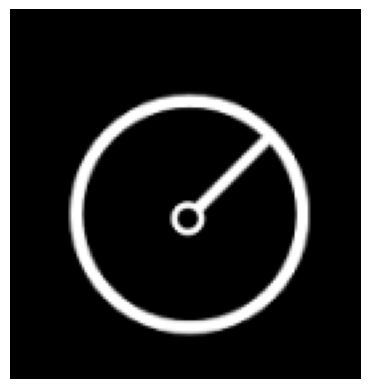

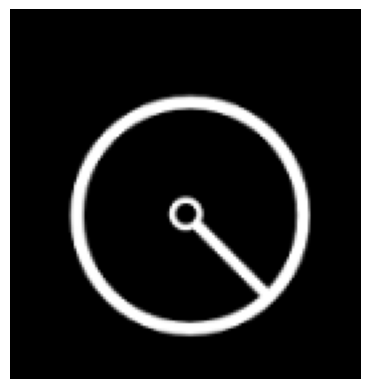

Remove commonality


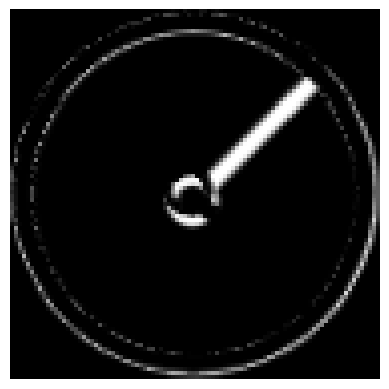

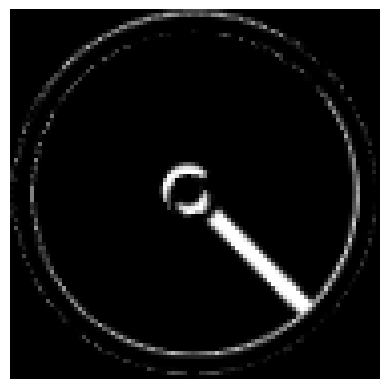

Best angle: 90, score: 15.477315689981097
90 15.477315689981097


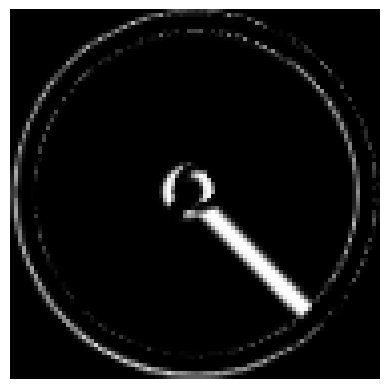

Trying an angle of 90


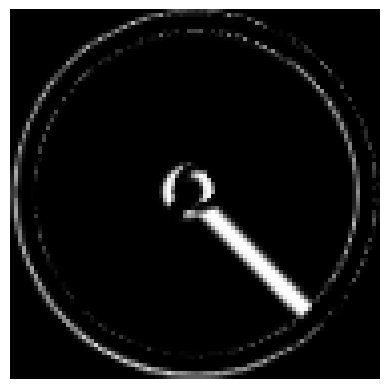

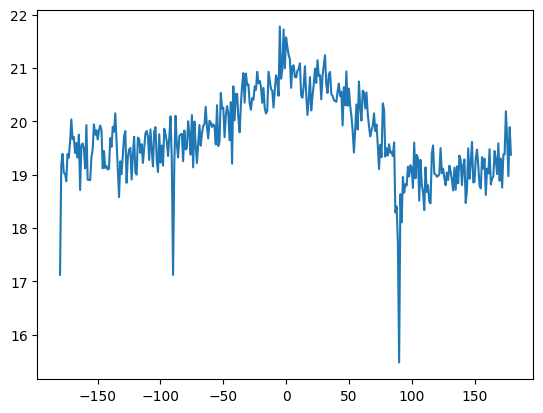

{-180: 17.123109640831757,
 -179: 19.182301512287335,
 -178: 19.390359168241964,
 -177: 19.035089792060493,
 -176: 19.0218572778828,
 -175: 18.87842627599244,
 -174: 19.388350661625708,
 -173: 19.31970699432892,
 -172: 19.620037807183365,
 -171: 20.03603497164461,
 -170: 19.663634215500945,
 -169: 19.708057655954633,
 -168: 19.406072778827976,
 -167: 19.593572778827976,
 -166: 19.320179584120982,
 -165: 19.75047258979206,
 -164: 18.71124763705104,
 -163: 19.550921550094518,
 -162: 19.585893194706994,
 -161: 19.481214555765597,
 -160: 19.119328922495274,
 -159: 19.930411153119092,
 -158: 18.906427221172024,
 -157: 18.900756143667298,
 -156: 18.897211720226842,
 -155: 19.324551039697543,
 -154: 19.474480151228732,
 -153: 19.944116257088847,
 -152: 19.749881852551987,
 -151: 19.833648393194707,
 -150: 19.659853497164463,
 -149: 19.828213610586012,
 -148: 19.92296786389414,
 -147: 19.83423913043478,
 -146: 19.11897448015123,
 -145: 19.44447069943289,
 -144: 19.123227788279774,
 -143: 19.16

In [32]:
# New approach: Use Gradient Descent or similar to learn the parameters of the augmentation.
# We have base augmentations: Rotate, Flipping, Stretching, Cropping, Color change, and Translation. (Potential: bitwise logic like XOR)

def get_angle(org, dest):
    # Try to find the angle that minimizes the difference between the two images
    # We will use the sum of absolute differences as a measure of similarity
    # We will try angles from -180 to 180 in steps of 1 degree
    angles = range(-180, 180)
    best_angle = None
    best_score = float('inf')
    for angle in angles:
        score = augmentation_score(RotateAugmentation(angle), org, dest)
        if score < best_score:
            best_score = score
            best_angle = angle
    print(f"Best angle: {best_angle}, score: {best_score}")
    return best_angle, best_score

def get_offset(org, dest):
    # Try to find the offset that minimizes the difference between the two images
    # We will use the sum of absolute differences as a measure of similarity
    # We will try offsets from -width to width and -height to height in steps of 1 pixel
    height, width = org.shape[:2]
    best_offset = None
    best_score = float('inf')
    for dx in range(-width, width):
        for dy in range(-height, height):
            translated = TranslateAugmentation(dx, dy)(org)
            score = np.sum(np.abs(translated - dest))
            if score < best_score:
                best_score = score
                best_offset = (dx, dy)
    print(f"Best offset: {best_offset}, score: {best_score}")
    return best_offset, best_score

def get_offset_x(org, dest):
    # Try to find the offset that minimizes the difference between the two images
    # We will use the sum of absolute differences as a measure of similarity
    # We will try offsets from -width to width and -height to height in steps of 1 pixel
    height, width = org.shape[:2]
    best_offset = None
    best_score = float('inf')
    for dx in range(-width, width):
        # translated = TranslateAugmentation(dx, 0)(org)
        # score = np.sum(np.abs(translated - dest))
        score = augmentation_score(TranslateAugmentation(dx, 0), org, dest)
        if score < best_score:
            best_score = score
            best_offset = (dx, 0)
    print(f"Best offset: {best_offset}, score: {best_score}")
    return best_offset, best_score
def get_mirror_angle(org, dest):
    # Try to find the angle that minimizes the difference between the two images
    # We will use the sum of absolute differences as a measure of similarity
    # We will try angles from -180 to 180 in steps of 1 degree
    angles = range(0, 180)
    best_angle = None
    best_score = float('inf')
    for angle in angles:
        flipped = FlipAugmentation(angle)(org)
        score = np.sum(np.abs(flipped - dest))
        if score < best_score:
            best_score = score
            best_angle = angle
    print(f"Best angle: {best_angle}, score: {best_score}")
    return best_angle, best_score

def test_rotate():
    # Testing rotation
    org = imgs[0]
    dest = imgs[1]
    show_image(org)
    show_image(dest)
    print(get_angle(org, dest))

def test_translate():
    # Testing translation
    org = imgs[0]
    # translate org
    print(org.shape)
    dest = shift(org, 40, 10)
    show_image(org)
    show_image(dest)
    final_offset, score = get_offset(org, dest)
    aug_img = shift(org, final_offset[0], final_offset[1])
    print("Result:")
    show_image(aug_img)

def test_rotate_2():
    # Test on umbrella dataset, where it is impossible to get a score of zero
    data = iq_test_to_squares(get_image('iq_images/iq16.png'))
    org = data[0]
    dest = data[1]
    show_image(org)
    show_image(dest)
    angle, score = get_angle(org, dest)
    print(angle, score)
    aug_img = RotateAugmentation(angle)(org)
    show_image(aug_img)
    # try an angle of 90
    aug_img = RotateAugmentation(90)(org)
    show_image(aug_img)
    print(f"Angle 90 score: {np.sum(np.abs(aug_img - dest))}")

# This test shows removing the base can help get the correct change
# works from 0 to 1, not from 1 to 2
def test_rotate_3():
    # test on clocks dataset, but first remove the commonalities (bitwise and)
    data = iq_test_to_squares(get_image('iq_images/iq17.png'))
    org = data[1]
    dest = data[2]
    # remove commonalities
    base = cv2.bitwise_and(org, dest)
    org = cv2.bitwise_xor(org, base)
    dest = cv2.bitwise_xor(dest, base)
    show_image(org)
    show_image(dest)
    angle, score = get_angle(org, dest)
    print(angle, score)
    aug_img = RotateAugmentation(angle)(org)
    show_image(aug_img)
    angle_test = 90
    print(f"Trying an angle of {angle_test}")
    aug_img = RotateAugmentation(angle_test)(org)
    show_image(aug_img)
    print(f"Angle {angle_test} score: {np.sum(np.abs(aug_img - dest))}")

# Similar to test 3, but now try to center the images
def test_rotate_4():
    data = iq_test_to_squares(get_image('iq_images/iq17.png'))
    org = data[1]
    dest = data[2]
    
    show_image(org)
    show_image(dest)
    org, dest = align_images(org, dest)
    # Need them to have the same size
    org = cv2.resize(org, (dest.shape[1], dest.shape[0]))
    print("Remove commonality")
    # remove commonalities
    base = cv2.bitwise_and(org, dest)
    org = cv2.bitwise_xor(org, base)
    dest = cv2.bitwise_xor(dest, base)
    show_image(org)
    show_image(dest)
    angle, score = get_angle(org, dest)
    print(angle, score)
    aug_img = RotateAugmentation(angle)(org)
    show_image(aug_img)
    angle_test = 90
    print(f"Trying an angle of {angle_test}")
    aug_img = RotateAugmentation(angle_test)(org)
    show_image(aug_img)
    # print(f"Angle {angle_test} score: {np.sum(np.abs(aug_img - dest) ** 2)}")

    # Try plotting the score for different angles
    angles = range(-180, 180)
    scores = [augmentation_score(RotateAugmentation(angle), org, dest) for angle in angles]
    plt.plot(angles, scores)
    plt.show()
    # create a mapping from angle to score
    angle_score_map = {angle: score for angle, score in zip(angles, scores)}
    return angle_score_map


# Try to translate test 4
def test_translate_2():
    # Testing translation
    data = iq_test_to_squares(get_image('iq_images/iq04.png'))
    org = data[0]
    dest = data[1]
    org, dest = align_images(org, dest, True)
    org, dest = remove_background(org, dest)
    print("Original:")
    show_image(org)
    print("Destination:")
    show_image(dest)
    print("Trying to find the best offset")

    final_offset, score = get_offset_x(org, dest)
    aug_img = shift(org, final_offset[0], final_offset[1])
    print("Result:")
    show_image(aug_img)
    # Try plotting the score for different offsets
    offset_x = range(-org.shape[1], org.shape[1])
    scores = [augmentation_score(TranslateAugmentation(dx, 0), org, dest) for dx in offset_x]
    plt.plot(offset_x, scores)
    plt.show()

# map = test_rotate_4()
test_rotate_4()
# test_translate_2()

iq04 - Boxes translating
Correct labels: 
[['Translate (-50, 0)', 'Translate (-50, 0)'], ['Translate (-50, -50)', 'Translate (-50, -50)'], ['Translate (0, -50)', 'N/A']]
Optimal parameter for Rotate: 119.04112776423035, score: 7.6530037546933665
Optimal parameter for Translate X: 27.248408744862335, score: 7.766270337922403
Optimal parameter for Translate Y: 33.55270900512156, score: 7.6530037546933665


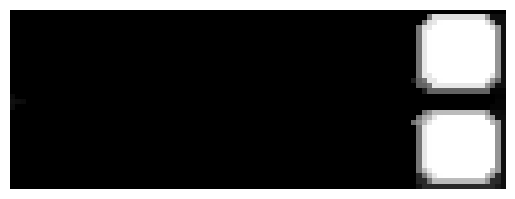

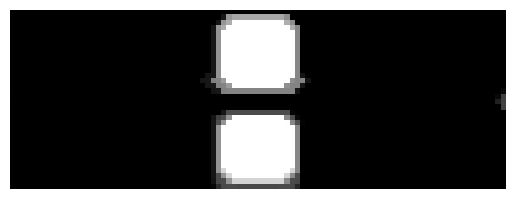

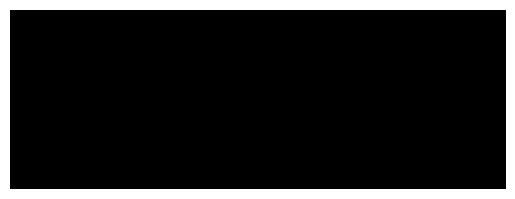

0->1: Got ('Rotate', 119.04112776423035), expected [Translate (-50, 0)]
Optimal parameter for Rotate: -39.91070136847007, score: 19.81640866873065
Optimal parameter for Translate X: -40.99087181596296, score: 8.564086687306501
Optimal parameter for Translate Y: 30.316080960457626, score: 11.244891640866873


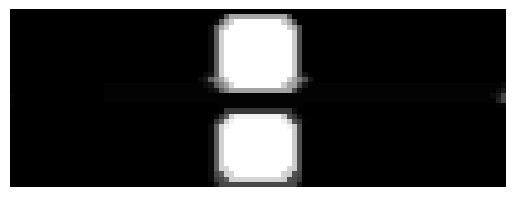

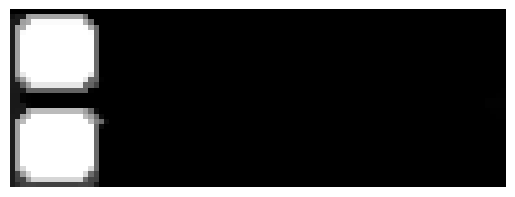

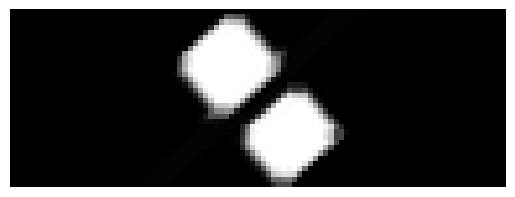

1->2: Got ('Translate X', -40.99087181596296), expected [Translate (-50, 0)]
Optimal parameter for Rotate: 22.51168224334057, score: 14.916613924050633
Optimal parameter for Translate X: 78.60302509948933, score: 10.11012658227848
Optimal parameter for Translate Y: -79.10110089832598, score: 10.11012658227848


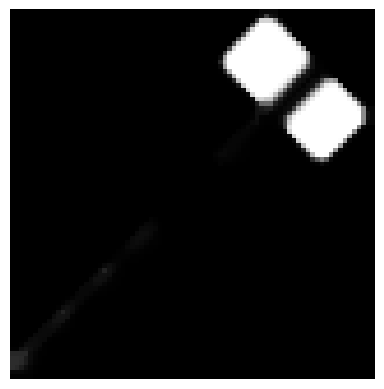

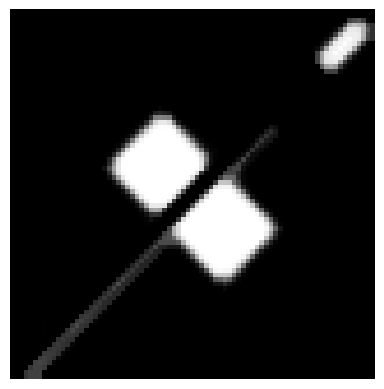

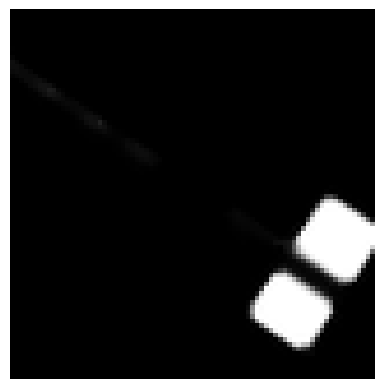

3->4: Got ('Translate X', 78.60302509948933), expected [Translate (-50, -50)]
Optimal parameter for Rotate: -41.719700915101015, score: 11.960601265822785
Optimal parameter for Translate X: -78.11233713709692, score: 4.2884493670886075
Optimal parameter for Translate Y: 79.59800010074868, score: 4.2884493670886075


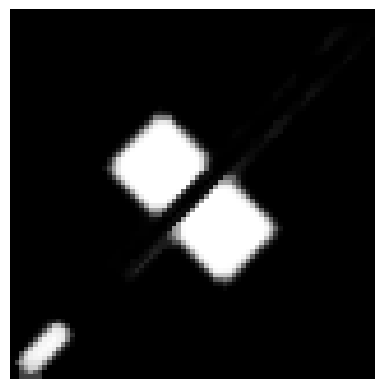

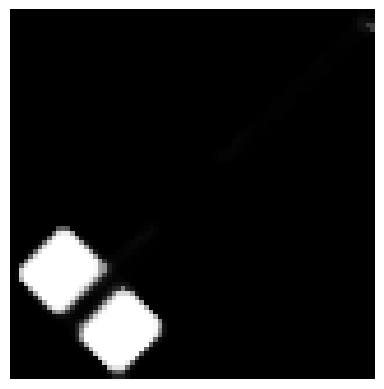

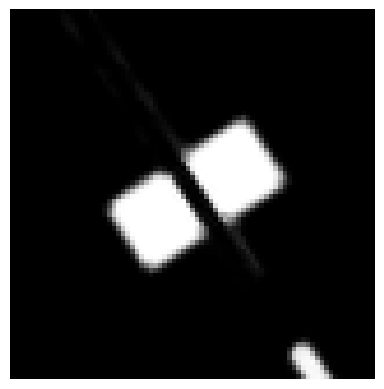

4->5: Got ('Translate X', -78.11233713709692), expected [Translate (-50, -50)]
Optimal parameter for Rotate: 123.51322058603462, score: 12.3343653250774
Optimal parameter for Translate X: -27.762852744520927, score: 14.130030959752322
Optimal parameter for Translate Y: -19.814197615643295, score: 12.3343653250774


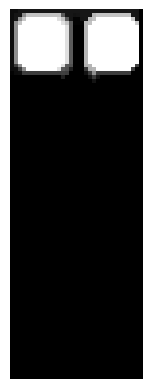

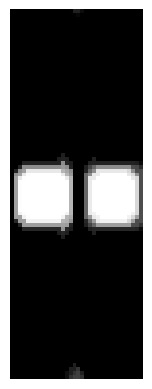

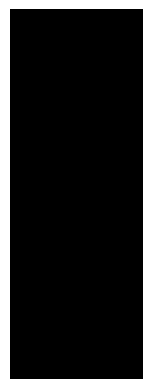

6->7: Got ('Rotate', 123.51322058603462), expected [Translate (0, -50)]
iq10 - Arrows rotating
Correct labels: 
[['Rotate -90', 'Rotate -90'], ['Rotate -90', 'Rotate -90'], ['Rotate -90', 'N/A']]
Optimal parameter for Rotate: 35.60172593402832, score: 19.2622027534418
Optimal parameter for Translate X: -84.04491970447135, score: 13.141551939924906
Optimal parameter for Translate Y: -92.94379355553303, score: 13.187609511889862


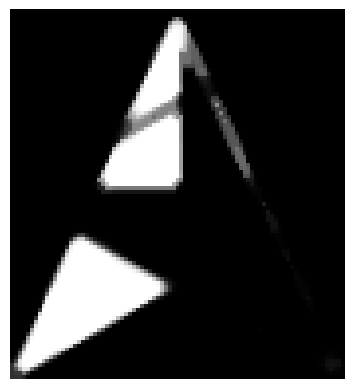

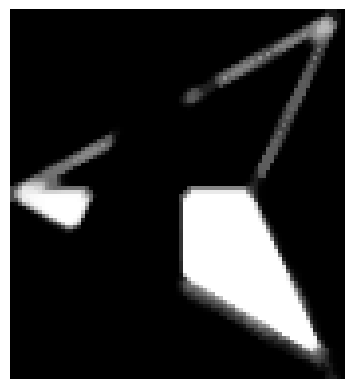

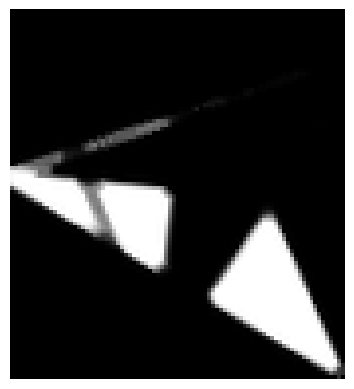

0->1: Got ('Translate X', -84.04491970447135), expected [Rotate -90]
Optimal parameter for Rotate: 48.26472276044488, score: 19.369619000494804
Optimal parameter for Translate X: -85.03368346570045, score: 12.112320633349826
Optimal parameter for Translate Y: 88.94198114011789, score: 12.119247897080653


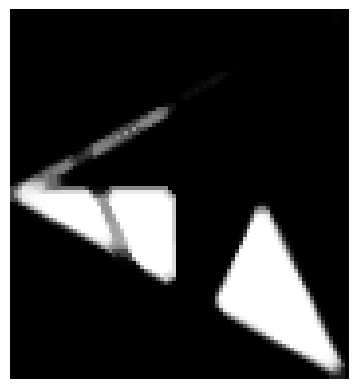

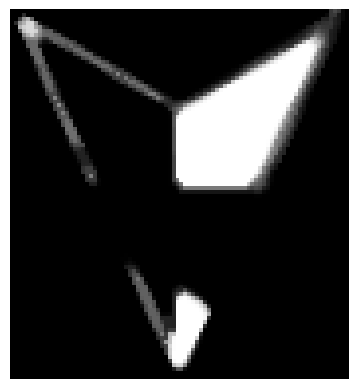

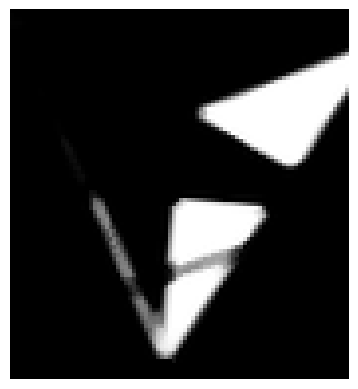

1->2: Got ('Translate X', -85.03368346570045), expected [Rotate -90]
Optimal parameter for Rotate: 38.52874868611032, score: 17.32327909887359
Optimal parameter for Translate X: -42.531158341023946, score: 11.36558197747184
Optimal parameter for Translate Y: 93.5276501183797, score: 8.92740926157697


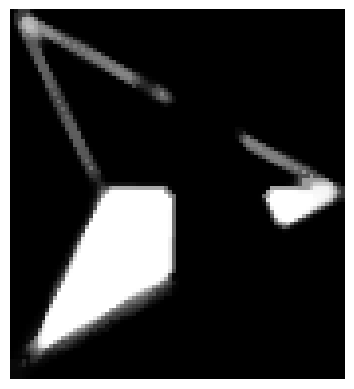

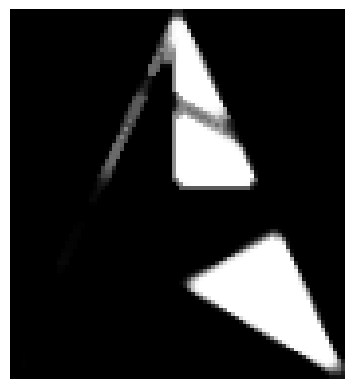

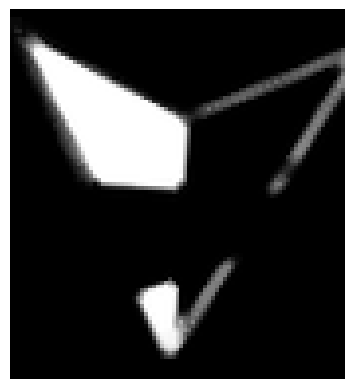

3->4: Got ('Translate Y', 93.5276501183797), expected [Rotate -90]
Optimal parameter for Rotate: 50.07372230707581, score: 19.999499374217773
Optimal parameter for Translate X: 84.57287510704548, score: 11.32465581977472
Optimal parameter for Translate Y: 51.03626987490044, score: 14.036545682102629


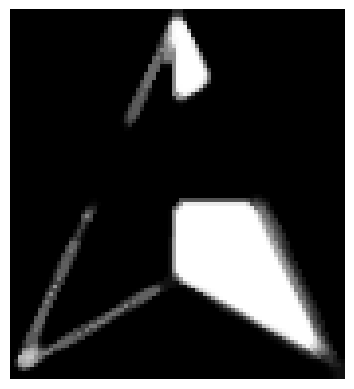

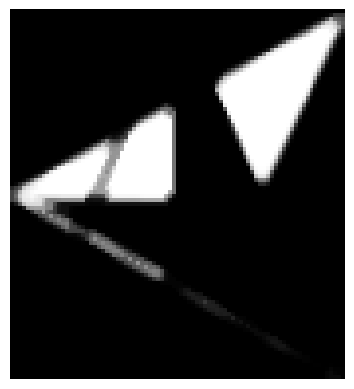

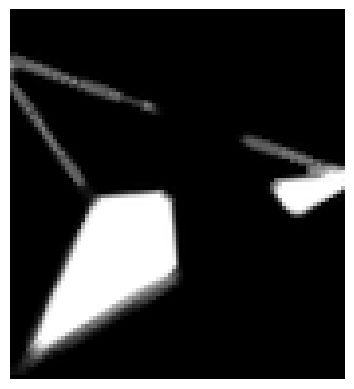

4->5: Got ('Translate X', 84.57287510704548), expected [Rotate -90]
Optimal parameter for Rotate: 45.76474687263408, score: 20.73116395494368
Optimal parameter for Translate X: 84.57287510704548, score: 13.892991239048811
Optimal parameter for Translate Y: -92.94379355553303, score: 13.954693366708385


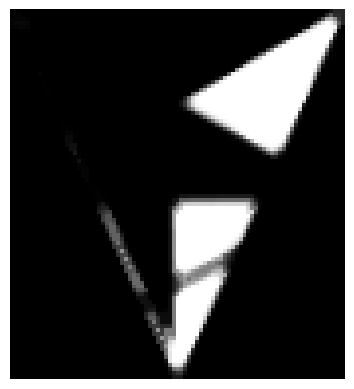

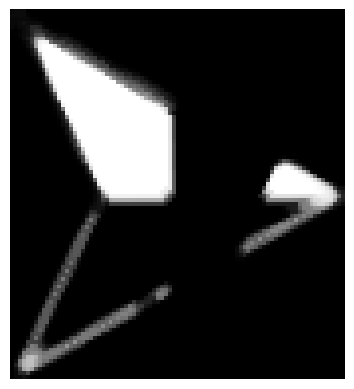

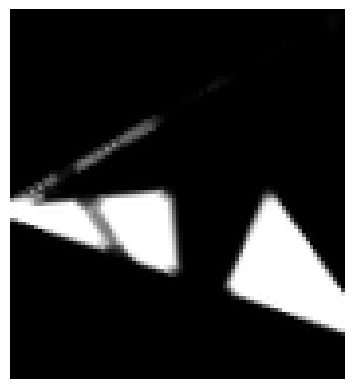

6->7: Got ('Translate X', 84.57287510704548), expected [Rotate -90]
iq16 - Umbrellas rotating
Correct labels: 
[['Rotate 90', 'Rotate 90'], ['Rotate 90', 'Rotate 90'], ['Rotate 90', 'N/A']]
Optimal parameter for Rotate: 90.1979471076815, score: 22.116050616050615
Optimal parameter for Translate X: 49.475027648394004, score: 20.84715284715285
Optimal parameter for Translate Y: 54.623043381753874, score: 22.69114219114219


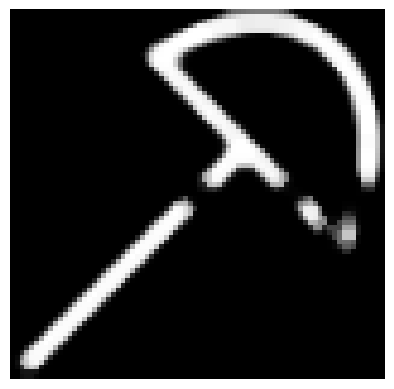

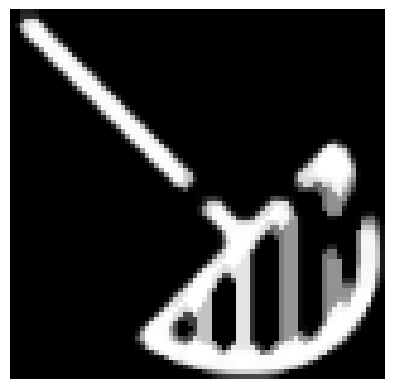

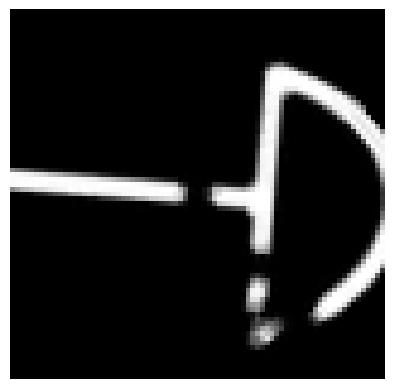

0->1: Got ('Translate X', 49.475027648394004), expected [Rotate 90]
Optimal parameter for Rotate: 90.1979471076815, score: 24.677348625400573
Optimal parameter for Translate X: 73.81326019646241, score: 13.679203912970147
Optimal parameter for Translate Y: 76.61307509697062, score: 13.701467363805026


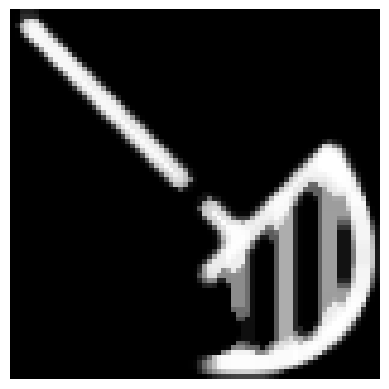

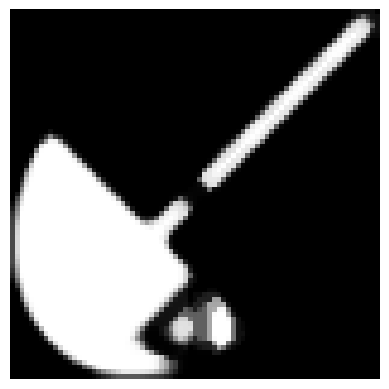

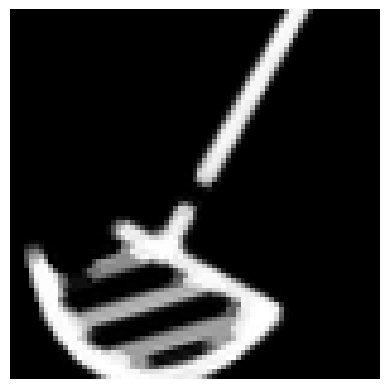

1->2: Got ('Translate X', 73.81326019646241), expected [Rotate 90]
Optimal parameter for Rotate: -37.674654957567924, score: 21.601787822567044
Optimal parameter for Translate X: -54.14477789942203, score: 15.477652217911958
Optimal parameter for Translate Y: 19.042424652845057, score: 17.939281497723055


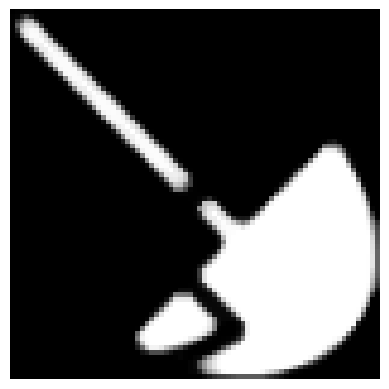

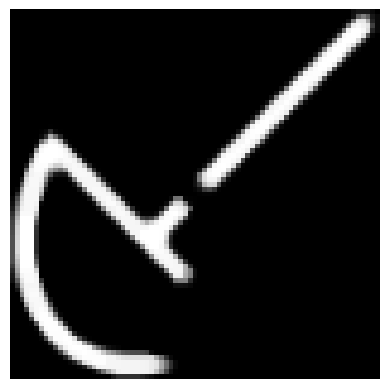

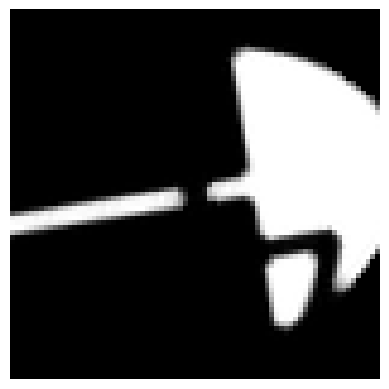

3->4: Got ('Translate X', -54.14477789942203), expected [Rotate 90]
Optimal parameter for Rotate: 90.6249939719527, score: 24.22111222111222
Optimal parameter for Translate X: -49.13631674585949, score: 22.684981684981686
Optimal parameter for Translate Y: -77.12357337586784, score: 22.384282384282383


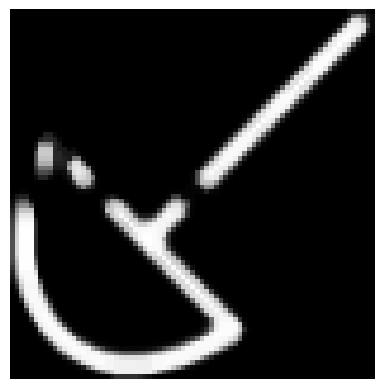

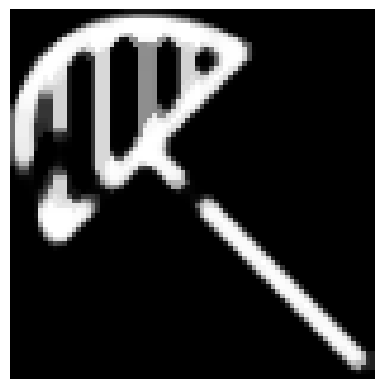

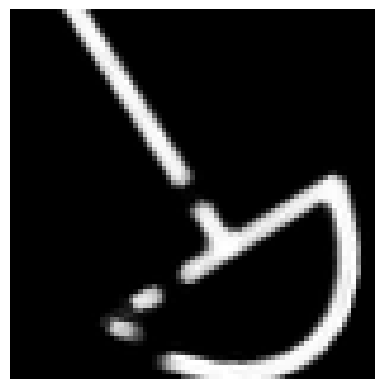

4->5: Got ('Translate Y', -77.12357337586784), expected [Rotate 90]
Optimal parameter for Rotate: 89.24304128959297, score: 22.374958374958375
Optimal parameter for Translate X: -75.36095980857996, score: 14.237429237429238
Optimal parameter for Translate Y: 77.60805009822997, score: 14.105727605727605


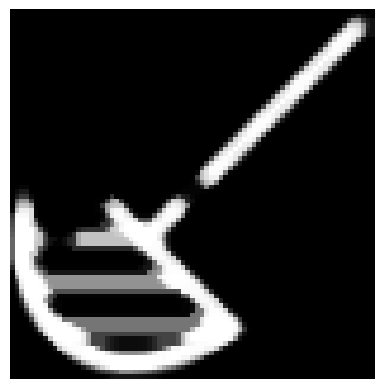

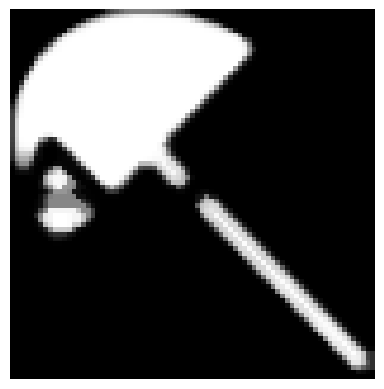

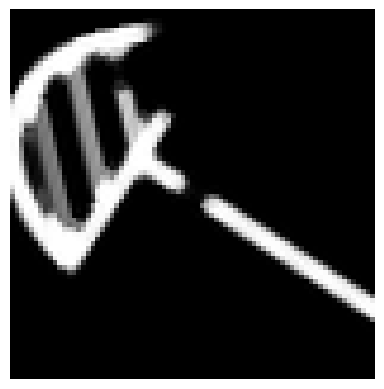

6->7: Got ('Translate Y', 77.60805009822997), expected [Rotate 90]
iq17 - Circles rotating
Correct labels: 
[['Rotate 45', 'Rotate 90'], ['Rotate 45', 'Rotate 90'], ['Rotate 45', 'N/A']]
Optimal parameter for Rotate: 44.64672366718301, score: 7.960224558050645
Optimal parameter for Translate X: -86.66863011669975, score: 4.855590062111801
Optimal parameter for Translate Y: -77.938498168086, score: 5.219421882465361


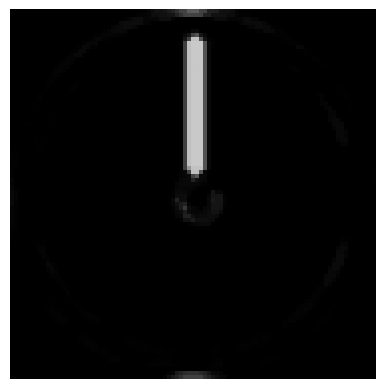

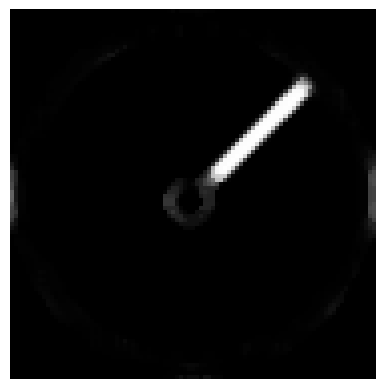

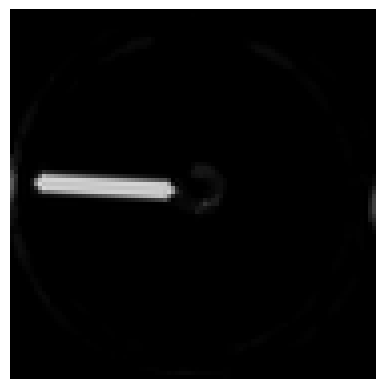

0->1: Got ('Translate X', -86.66863011669975), expected [Rotate 45]
Optimal parameter for Rotate: 91.0520408362239, score: 10.084002835538753
Optimal parameter for Translate X: 88.19246672824079, score: 6.360822306238186
Optimal parameter for Translate Y: 87.04959856266856, score: 6.144966918714556


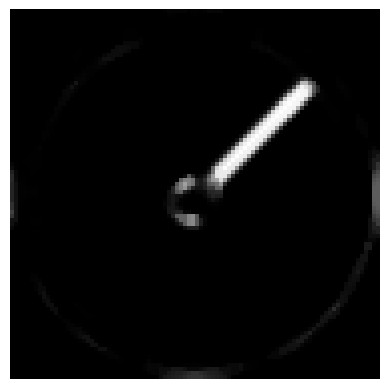

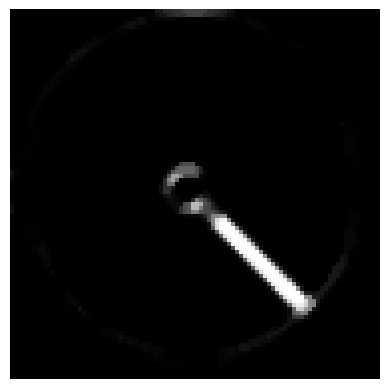

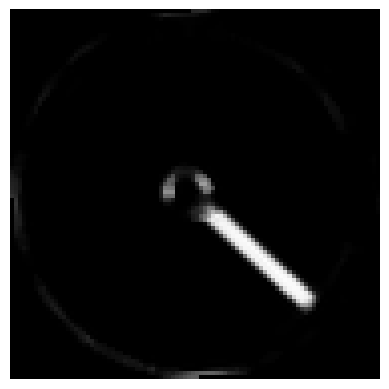

1->2: Got ('Translate Y', 87.04959856266856), expected [Rotate 90]
Optimal parameter for Rotate: 43.26477098482327, score: 10.502953686200378
Optimal parameter for Translate X: 88.19246672824079, score: 6.8011578449905485
Optimal parameter for Translate Y: 88.19246672824079, score: 6.712429111531191


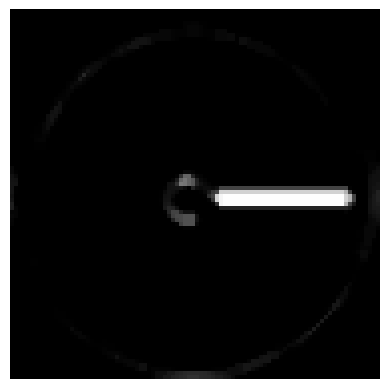

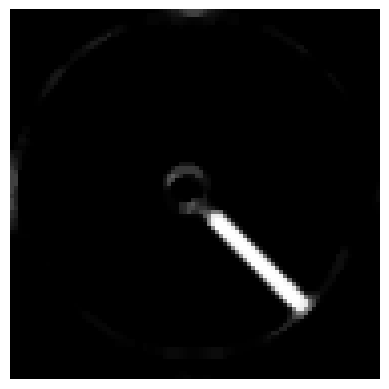

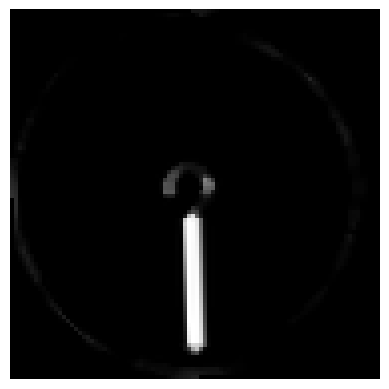

3->4: Got ('Translate Y', 88.19246672824079), expected [Rotate 45]
Optimal parameter for Rotate: 172.4185136428863, score: 8.686082230623818
Optimal parameter for Translate X: -88.19246672824079, score: 7.3484168241965975
Optimal parameter for Translate Y: 90.04166626479685, score: 7.305411153119093


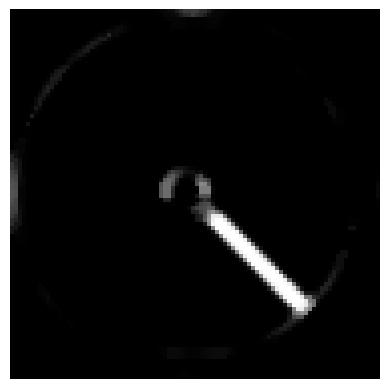

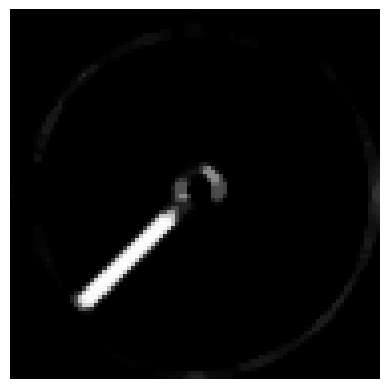

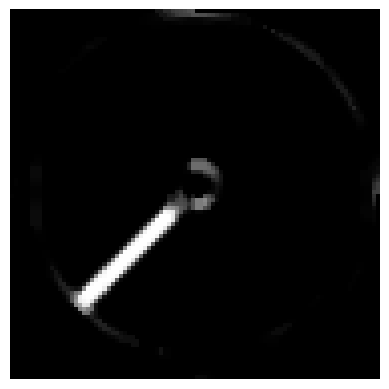

4->5: Got ('Translate Y', 90.04166626479685), expected [Rotate 90]
Optimal parameter for Rotate: 41.45577143819234, score: 8.166115311909262
Optimal parameter for Translate X: -90.61310034758296, score: 4.725425330812855
Optimal parameter for Translate Y: 89.47023218201073, score: 4.701441398865785


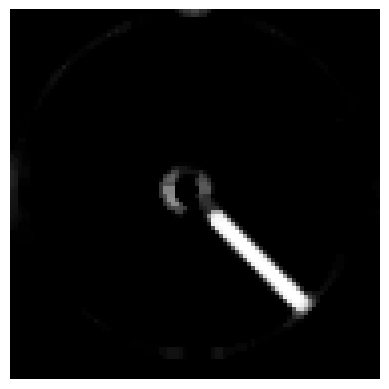

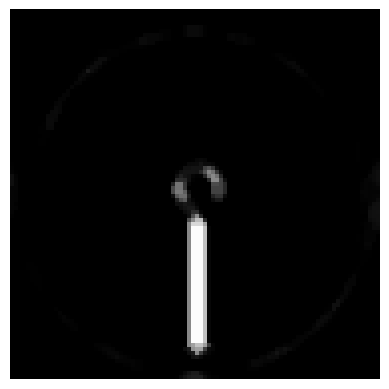

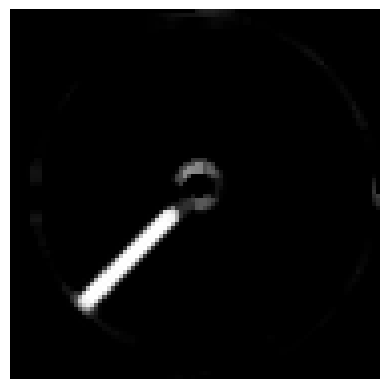

6->7: Got ('Translate Y', 89.47023218201073), expected [Rotate 45]


In [29]:
# Gradient descent (or sort of like binary search?) to find the optimal angle, offset, or other parameters

def gradient_descent(create_augmentation, parameter_range, org, dest, debug=False):
    def score(parameter):
        return augmentation_score(create_augmentation(parameter), org, dest)
    start, stop = parameter_range
    golden_ratio = (1 + 5 ** 0.5) / 2
    max_iterations = 100
    tolerance = 1
    for _ in range(max_iterations):
        if debug:
            print(f"Range: {start} - {stop}")
        range_size = stop - start
        if range_size < tolerance:
            break

        mid1 = stop - range_size / golden_ratio
        mid2 = start + range_size / golden_ratio

        score1 = score(mid1)
        score2 = score(mid2)

        if score1 < score2:
            stop = mid2
        else:
            start = mid1

    optimal_parameter = (start + stop) / 2
    return optimal_parameter

def learn_parameters(org, dest):
    # The augmentation could be any of the base augmentations
    augmentations = [RotateAugmentation, lambda dx: TranslateAugmentation(dx, 0), lambda dy: TranslateAugmentation(0, dy)]
    names = ["Rotate", "Translate X", "Translate Y"]
    parameters = [(-180, 180), (-org.shape[1], org.shape[1]), (-org.shape[0], org.shape[0])]
    best_score = float('inf')
    best_result = None
    for name, create_augmentation, parameter_range in zip(names, augmentations, parameters):
        optimal_parameter = gradient_descent(create_augmentation, parameter_range, org, dest)
        score = augmentation_score(create_augmentation(optimal_parameter), org, dest)
        print(f"Optimal parameter for {name}: {optimal_parameter}, score: {score}")
        if score < best_score:
            best_score = score
            best_result = (name, optimal_parameter)
    return best_result 


def test_gradient_descent():
    # Test first with rotation
    data = iq_test_to_squares(get_image('iq_images/iq17.png'))
    org = data[1]
    dest = data[2]
    org, dest = align_images(org, dest, True)
    org, dest = remove_background(org, dest)
    print("Original:")
    show_image(org)
    print("Destination:")
    show_image(dest)
    print("Trying to find the best angle")
    optimal_angle = gradient_descent(RotateAugmentation, (-180, 180), org, dest)
    print(f"Optimal angle: {optimal_angle}")

def test_multiple():
    names = []
    images = []
    correct_translations = []
    boxes_translating = iq_test_to_squares(get_image('iq_images/iq04.png'))
    names.append("iq04 - Boxes translating")
    images.append(boxes_translating)
    correct_translations.append([["Translate (-50, 0)", "Translate (-50, 0)"],
                                 ["Translate (-50, -50)", "Translate (-50, -50)"],
                                 ["Translate (0, -50)", "N/A"]])
    arrows_rotating = iq_test_to_squares(get_image('iq_images/iq10.png'))
    names.append("iq10 - Arrows rotating")
    images.append(arrows_rotating)
    correct_translations.append([["Rotate -90", "Rotate -90"],
                                 ["Rotate -90", "Rotate -90"],
                                 ["Rotate -90", "N/A"]])
    umbrellas_rotating = iq_test_to_squares(get_image('iq_images/iq16.png'))
    names.append("iq16 - Umbrellas rotating")
    images.append(umbrellas_rotating)
    correct_translations.append([["Rotate 90", "Rotate 90"],
                                 ["Rotate 90", "Rotate 90"],
                                 ["Rotate 90", "N/A"]])
    circles_rotating = iq_test_to_squares(get_image('iq_images/iq17.png'))
    names.append("iq17 - Circles rotating")
    images.append(circles_rotating)
    correct_translations.append([["Rotate 45", "Rotate 90"],
                                 ["Rotate 45", "Rotate 90"],
                                 ["Rotate 45", "N/A"]])
    for name, image, label in zip(names, images, correct_translations):
        print(name)
        print(f"Correct labels: \n{label}")
        transitions = [(0, 1), (1, 2), (3, 4), (4, 5), (6, 7)]
        labels = [label[0][0], label[0][1], label[1][0], label[1][1], label[2][0]]
        for l, transition in zip(labels, transitions):
            start, end = transition
            org = image[start]
            dest = image[end]
            org, dest = align_images(org, dest, True)
            org, dest = remove_background(org, dest)
            best_result = learn_parameters(org, dest)
            name, parameter = best_result
            if best_result[0] == 'Translation X':
                augmented = TranslateAugmentation(parameter, 0)(org)
            elif best_result[0] == 'Translation Y':
                augmented = TranslateAugmentation(0, parameter)(org)
            else:
                augmented = RotateAugmentation(parameter)(org)
            show_image(org)
            show_image(dest)
            show_image(augmented)
            print(f"{start}->{end}: Got {best_result}, expected [{l}]")


# test_gradient_descent()
test_multiple()

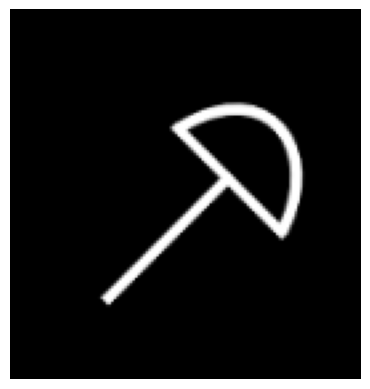

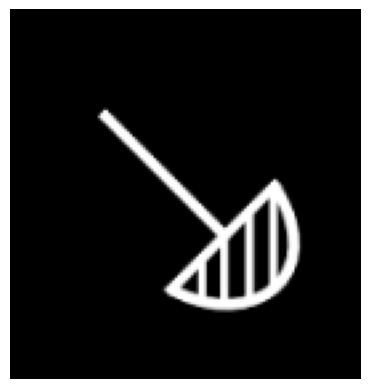

error: OpenCV(4.9.0) /io/opencv/modules/calib3d/src/fundam.cpp:385: error: (-28:Unknown error code -28) The input arrays should have at least 4 corresponding point sets to calculate Homography in function 'findHomography'


In [31]:
def merge_panorama(image1, image2):
    
    # Initialize the feature detector
    sift = cv2.SIFT_create()

    # Detect features and compute descriptors
    keypoints1, descriptors1 = sift.detectAndCompute(image1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(image2, None)

    # Match features
    matcher = cv2.BFMatcher()
    matches = matcher.knnMatch(descriptors1, descriptors2, k=2)

    # Filter matches using the Lowe's ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    # Extract location of good matches
    points1 = np.float32([keypoints1[m.queryIdx].pt for m in good_matches])
    points2 = np.float32([keypoints2[m.trainIdx].pt for m in good_matches])

    # Find homography
    H, _ = cv2.findHomography(points2, points1, cv2.RANSAC)

    # Warp images
    height, width, channels = image1.shape
    result = cv2.warpPerspective(image2, H, (width * 2, height))

    # Copy image1 onto the panorama
    result[0:image1.shape[0], 0:image1.shape[1]] = image1
    return result

# try it out
circles_rotating = iq_test_to_squares(get_image('iq_images/iq16.png'))
img1 = circles_rotating[0]
img2 = circles_rotating[1]
show_image(img1)
show_image(img2)
show_image(merge_panorama(img1, img2))